# Trying to use anomaly detection approaches to detect different activities using data from: https://www.kaggle.com/malekzadeh/motionsense-dataset

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.models import Model

from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
sess = tf.InteractiveSession()

/Users/Vlad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
data_walking = pd.read_csv('../motionsense-dataset/A_DeviceMotion_data/wlk_7/sub_1.csv')

In [4]:
data_downstairs_1 = pd.read_csv('../motionsense-dataset/A_DeviceMotion_data/dws_1/sub_1.csv')
data_downstairs_2 = pd.read_csv('../motionsense-dataset/A_DeviceMotion_data/dws_2/sub_1.csv')
data_downstairs_3 = pd.read_csv('../motionsense-dataset/A_DeviceMotion_data/dws_11/sub_1.csv')

In [5]:
data_walking.shape, data_downstairs_1.shape, data_downstairs_2.shape, data_downstairs_3.shape

((5439, 13), (1751, 13), (2458, 13), (896, 13))

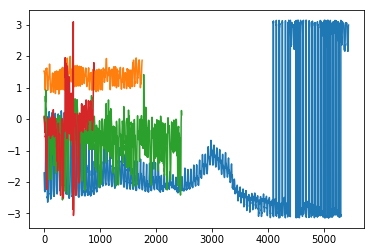

In [6]:
plt.plot(data_walking.iloc[:, 1])
plt.plot(data_downstairs_1.iloc[:, 1])
plt.plot(data_downstairs_2.iloc[:, 1])
plt.plot(data_downstairs_3.iloc[:, 1]);

In [7]:
X_train = np.concatenate([data_downstairs_1, data_downstairs_2, data_downstairs_3], axis=0)
X_test = data_walking.values

### Detection of normal behaviour(walking downstairs) and outlier - walking with non NN approach

In [8]:
def accuracy(X_pred):
    if not isinstance(X_pred, pd.Series):
        X_pred = pd.Series(X_pred)
    return np.array(X_pred.value_counts())[X_pred.value_counts().index == -1] / X_pred.shape[0]

#### One class svm vs. elliptic envelope

In [9]:
scaler = MinMaxScaler()
ocs = OneClassSVM(nu=0.1)
pipeline_ocs = Pipeline([('scaler', scaler), ('OneClassSVM', ocs)])
pipeline_ocs.fit(X_train)
acc_ocs = accuracy(pipeline_ocs.predict(X_test))
acc_ocs

array([0.91358706])

In [10]:
ell = EllipticEnvelope(support_fraction=1., contamination=0.261)
pipeline_ell = Pipeline([('scaler', scaler), ('elliptic', ell)])
pipeline_ell.fit(X_train)
acc_ell = accuracy(pipeline_ell.predict(X_test))
acc_ell

array([0.96414782])

In [11]:
print("EllipticEnvelope score: %.5f, One class svm accuracy: %.5f"%(acc_ell, acc_ocs))

EllipticEnvelope score: 0.96415, One class svm accuracy: 0.91359


### Detection of outliers between two people walking downstairs

In [12]:
X_sub_train = data_downstairs_1.values
X_sub_test = data_downstairs_2.values

In [13]:
pipeline_ocs.fit(X_sub_train)
pipeline_ell.fit(X_sub_train)

acc_ocs_sub = accuracy(pipeline_ocs.predict(X_sub_test))
acc_ell_sub = accuracy(pipeline_ell.predict(X_sub_test))
print("EllipticEnvelope score: %.5f, One class svm accuracy: %.5f"%(acc_ell_sub, acc_ocs_sub))

EllipticEnvelope score: 1.00000, One class svm accuracy: 1.00000


### AutoEncoder approach for classifying different types of activities

#### Model

In [14]:
dropout_coef = 0.25

In [30]:
def ae(input_shape):
    encoding_dim = 4
    input_layer = Input(shape=(input_shape, ))
    encoder = Dense(encoding_dim, activation='elu',
                   activity_regularizer = keras.regularizers.l1_l2(1e-4))(input_layer)
#     encoder = BatchNormalization()(encoder)
#     encoder = Dropout(dropout_coef)(encoder)
    encoder = Dense(int(encoding_dim / 2), activation='elu',
                   activity_regularizer = keras.regularizers.l1_l2(1e-4))(encoder)
#     encoder = BatchNormalization()(encoder)
#     encoder = Dropout(dropout_coef)(encoder)

    code = Dense(1, activation='linear')(encoder)
    decoder = Dense(int(encoding_dim / 2), activation='elu')(code)
    decoder = Dense(encoding_dim, activation='elu')(decoder)

    out = Dense(input_shape, activation='linear')(decoder)

    model = Model(input_layer, out)
    return model

In [16]:
def ae_2(input_shape):
    encoding_dim = 4
    input_layer = Input(shape=(input_shape, ))
    encoder = Dense(encoding_dim, activation='elu')(input_layer)
    

    encoder = Dense(int(encoding_dim / 2), activation='elu')(encoder)
    decoder = Dense(int(encoding_dim / 2), activation='elu')(encoder)

    out = Dense(input_shape, activation='elu')(decoder)

    model = Model(input_layer, out)
    return model

In [31]:
inp_shape = X_train.shape[1]
model = ae(inp_shape)

In [32]:
nb_epoch = 200
batch_size = 16
model.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
early = EarlyStopping(patience=5, verbose=1)
history = model.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                   callbacks=[early]).history

Train on 5105 samples, validate on 5439 samples
Epoch 1/200
5105/5105 [==============================] - 2s 374us/step - loss: 112724.4002 - acc: 0.2660 - val_loss: 759225.7756 - val_acc: 1.0000
Epoch 2/200
5105/5105 [==============================] - 1s 231us/step - loss: 64405.6787 - acc: 0.9990 - val_loss: 67670.0491 - val_acc: 0.9998
Epoch 3/200
5105/5105 [==============================] - 1s 231us/step - loss: 4999.4869 - acc: 0.9982 - val_loss: 21575.4239 - val_acc: 0.9996
Epoch 4/200
5105/5105 [==============================] - 1s 233us/step - loss: 2119.4551 - acc: 0.9990 - val_loss: 12178.0845 - val_acc: 0.9998
Epoch 5/200
5105/5105 [==============================] - 1s 238us/step - loss: 1281.8748 - acc: 0.9976 - val_loss: 8029.2260 - val_acc: 0.9998
Epoch 6/200
5105/5105 [==============================] - 1s 244us/step - loss: 890.1508 - acc: 0.9975 - val_loss: 5868.1605 - val_acc: 0.9998
Epoch 7/200
5105/5105 [==============================] - 1s 258us/step - loss: 654.9158

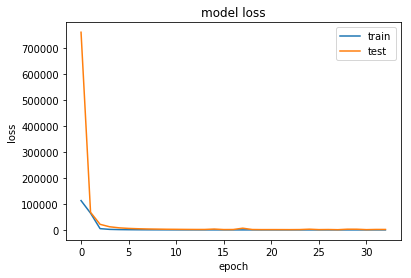

In [33]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');


In [34]:
preds = model.predict(X_test)
preds_train = model.predict(X_train)
mse_test = np.mean(np.power(X_test - preds, 2), axis=1)
mse_train = np.mean(np.power(X_train - preds_train, 2), axis=1)

error_df_test = pd.DataFrame([np.ones((X_test.shape[0], )), mse_test])
error_df_train = pd.DataFrame([np.zeros((X_train.shape[0], )), mse_train])
error_df_test, error_df_train = error_df_test.T, error_df_train.T

In [35]:
error_df = pd.concat([error_df_test, error_df_train], axis=0)

In [36]:
np.random.shuffle(error_df.values)

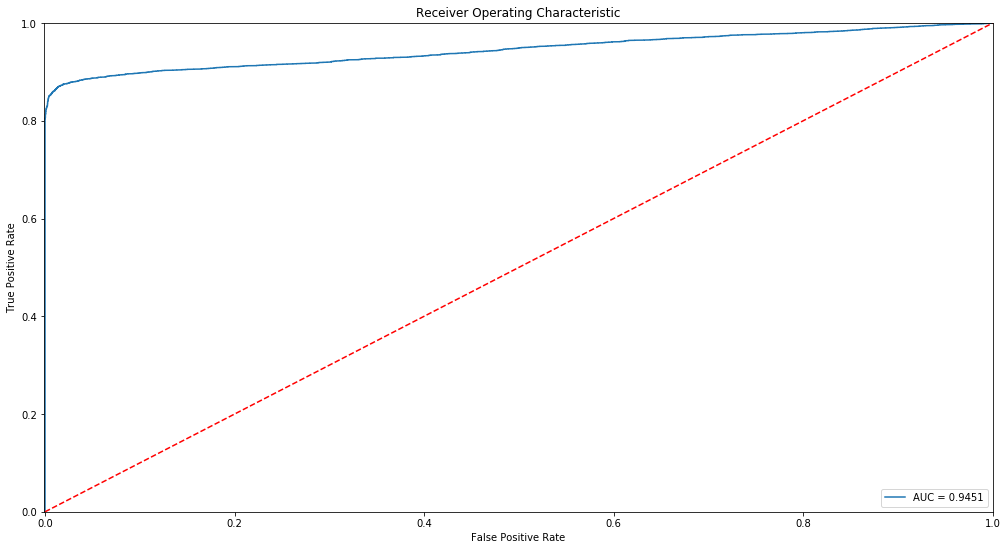

In [37]:
fpr, tpr, thresholds = roc_curve(error_df.iloc[:, 0], error_df.iloc[:, 1])
roc_auc = auc(fpr, tpr)

plt.subplots(figsize=(17, 9))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### Autoencoder for distinguishing two people involved in same activity

In [24]:
def ae_sub(input_shape):
    encoding_dim = 4
    input_layer = Input(shape=(input_shape, ))
    encoder = Dense(64, activation='elu')(input_layer)
    encoder = Dense(64, activation='elu')(encoder)
    code = Dense(1, activation='linear')(encoder)
    decoder = Dense(64, activation='elu')(code)
    decoder = Dense(64, activation='elu')(decoder)

    out = Dense(input_shape, activation='linear')(decoder)

    model = Model(input_layer, out)
    return model

In [43]:
inp_shape_subs = X_sub_train.shape[1]
model_subs = ae(inp_shape_subs)

In [44]:
nb_epoch = 100
batch_size = 16
model_subs.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
early = EarlyStopping(patience=5, verbose=1)
history_subs = model_subs.fit(X_sub_train, X_sub_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_sub_test, X_sub_test),
                    verbose=1,
                   callbacks=[early]).history

Train on 1751 samples, validate on 2458 samples
Epoch 1/100
1751/1751 [==============================] - 1s 761us/step - loss: 111748.5045 - acc: 5.7110e-04 - val_loss: 202053.0400 - val_acc: 8.1367e-04
Epoch 2/100
1751/1751 [==============================] - 0s 234us/step - loss: 96779.1993 - acc: 0.0051 - val_loss: 181041.3740 - val_acc: 4.0683e-04
Epoch 3/100
1751/1751 [==============================] - 0s 244us/step - loss: 88429.7890 - acc: 0.0417 - val_loss: 168560.9987 - val_acc: 0.1408
Epoch 4/100
1751/1751 [==============================] - 0s 234us/step - loss: 83496.1778 - acc: 0.6813 - val_loss: 161448.8967 - val_acc: 0.9996
Epoch 5/100
1751/1751 [==============================] - 0s 229us/step - loss: 80713.6446 - acc: 0.9989 - val_loss: 157513.1306 - val_acc: 0.9996
Epoch 6/100
1751/1751 [==============================] - 0s 234us/step - loss: 79203.1034 - acc: 0.9989 - val_loss: 155451.1847 - val_acc: 0.9996
Epoch 7/100
1751/1751 [==============================] - 0s 234

In [48]:
preds_sub_test = model_subs.predict(X_sub_test)
preds_sub_train = model_subs.predict(X_sub_train)
mse_sub_test = np.mean(np.power(X_sub_test - preds_sub_test, 2), axis=1)
mse_sub_train = np.mean(np.power(X_sub_train - preds_sub_train, 2), axis=1)

error_df_sub_test = pd.DataFrame([np.ones((X_sub_test.shape[0], )), mse_sub_test])
error_df_sub_train = pd.DataFrame([np.zeros((X_sub_train.shape[0], )), mse_sub_train])
error_df_sub_test, error_df_sub_train = error_df_sub_test.T, error_df_sub_train.T

In [49]:
error_df_sub = pd.concat([error_df_sub_test, error_df_sub_train], axis=0)
np.random.shuffle(error_df_sub.values)

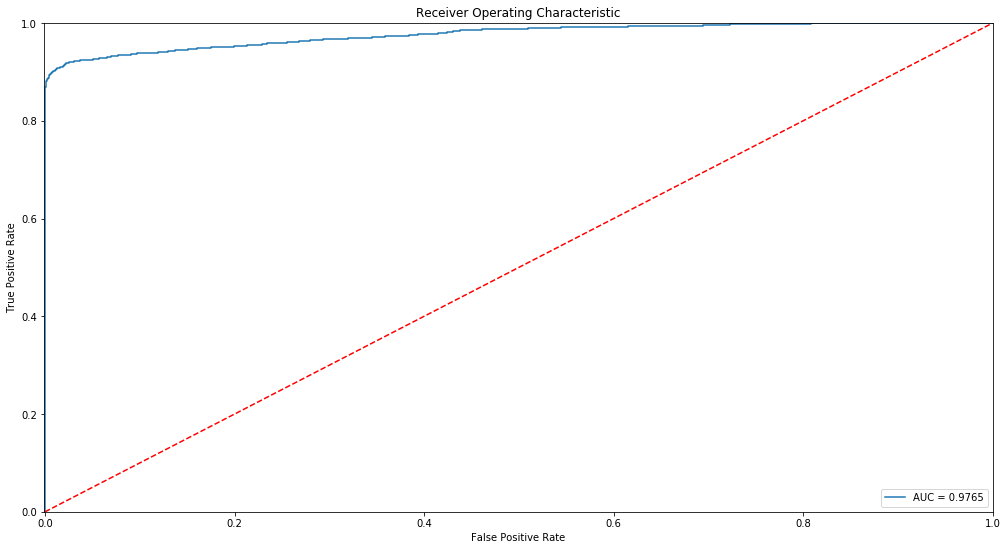

In [50]:
fpr, tpr, thresholds = roc_curve(error_df_sub.iloc[:, 0], error_df_sub.iloc[:, 1])
roc_auc = auc(fpr, tpr)

plt.subplots(figsize=(17, 9))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

#### AutoEncoder doing well on both distinguishing different activities and different people doing the same